In [275]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx

from opt_utils import *
from linalg_utils import *

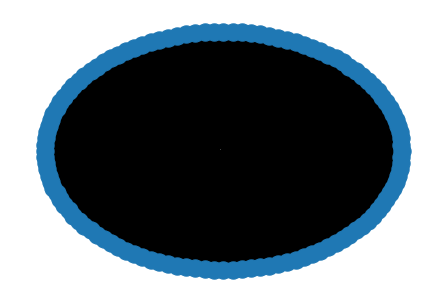

In [277]:
graph_file = "johnson16-2-4.mtx"
graph_type = 1

G = nx.complement(load_graph(graph_file, graph_type))
n = len(G)

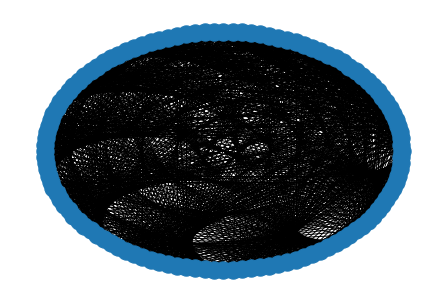

In [278]:
nx.draw(G, nx.circular_layout(G))


## Lovasz

In [279]:
Z = cp.Variable((n,n), PSD=True)

In [280]:
J = cp.Parameter((n,n), symmetric=True, value=np.ones((n,n)))

In [281]:
constraints_lovasz = [ cp.trace(Z) == 1 ]
constraints_lovasz += [ Z[i][j] == 0  for (i,j) in G.edges ]

In [283]:
prob_lovasz = cp.Problem(cp.Maximize(cp.trace(J @ Z)), constraints_lovasz)
prob_lovasz.solve(solver=cp.SCS, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jul 28 10:17:32 PM: Your problem has 14400 variables, 1681 constraints, and 14400 parameters.
(CVXPY) Jul 28 10:17:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 10:17:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 10:17:32 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 28 10:17:32 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jul 28 10:17:32 PM: Applying reduction FlipObjective
(CVXPY) Jul 28 10:17:32 PM: Applying red

/home/ivanightingale/miniconda3/envs/convex/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:187: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


(CVXPY) Jul 28 10:17:38 PM: Applying reduction SCS


KeyboardInterrupt: 

In [ ]:
Z_val = Z.value

In [ ]:
Z_center = 1 / n * np.eye(n)

### Fixed point iteration

In [ ]:
fixed_point_iteration(prob_lovasz, Z, -Z_center)

In [ ]:
Z_fixed_point = Z.value
Z.value = Z_val

In [ ]:
Z_vec = recover_incidence_vector(Z_fixed_point, "lovasz")
nx.draw(G, nx.circular_layout(G), node_color=Z_vec)

## Grotschel

In [ ]:
X = cp.Variable((n,n), symmetric=True)
x = cp.Variable((n,1), nonneg=True)

X_plus = cp.bmat([[cp.Constant([[1]]), x.T], [x, X]])

In [ ]:
e = cp.Parameter(n, value=np.ones(n))

In [ ]:
constraints_grotschel = [ X_plus >> 0 ]
constraints_grotschel += [ X[i][i] == x[i] for i in range(n)]
constraints_grotschel += [ X[i][j] == 0 for (i,j) in G.edges ]

In [ ]:
# prob_grotschel = cp.Problem(cp.Maximize(e @ x), constraints_grotschel)  # slightly different from result of maximizing tr(X)
prob_grotschel = cp.Problem(cp.Maximize(cp.trace(X)), constraints_grotschel)
prob_grotschel.solve()

In [ ]:
X_val = X.value
x_val = x.value

In [ ]:
prob_center_grotschel = cp.Problem(cp.Maximize(cp.log_det(X_plus)), constraints_grotschel)

prob_center_grotschel.solve()

X_center = X.value
x_center = x.value
X.value = X_val
x.value = x_val

In [ ]:
X_center

In [ ]:
plot_matrix_heatmap(X_center)

### Fixed point iteration

In [ ]:
fixed_point_iteration(prob_grotschel, X, -X_center)

In [ ]:
X_fixed_point = X.value
X.value = X_val
x.value = x_val

In [ ]:
X_vec = recover_incidence_vector(X_fixed_point, "grotschel")
nx.draw(G, nx.circular_layout(G), node_color=X_vec)

## Benson & Ye

In [ ]:
V = cp.Variable((n+1, n+1), PSD=True)

In [ ]:
constraints_benson = [ V[i][i] == 1 for i in range(n+1) ]
constraints_benson += [ V[i][i] + V[j][j] + V[n][n] + 2 * (V[i][j] + V[i][n] + V[j][n]) == 1 for (i,j) in G.edges]

In [ ]:
benson_mat = np.block([[0.5 * np.eye(n), np.array([[0.25]] * n)], [np.array([[0.25]] * n).T, 0]])
prob_benson = cp.Problem(cp.Maximize(cp.trace(benson_mat @ V)), constraints_benson)

In [ ]:
prob_benson.solve()

In [ ]:
V_val = remove_small_eigenvalues(V.value)

In [ ]:
prob_center_benson = cp.Problem(cp.Maximize(cp.log_det(V)), constraints_benson)

prob_center_benson.solve()

V_center = V.value
V.value = V_val

### Fixed point iteration

In [ ]:
fixed_point_iteration(prob_benson, V, -V_center)

In [ ]:
V_fixed_point = V.value
V.value = V_val

In [ ]:
V_vec = recover_incidence_vector(V_fixed_point, "benson")
nx.draw(G, nx.circular_layout(G), node_color=V_vec)

### Hyperplane rounding

In [ ]:
benson_cost = lambda v : np.trace(benson_mat @ np.outer(v, v))

max_cost = -np.Inf
max_v = None
for i in range(100):
    _, v = hyperplane_rounding(decompose_psd(V_val), benson_cost, n_iter=1)
    for (i,j) in G.edges:
        if np.abs(v[i] + v[j] + v[n]) != 1:
            if np.abs(v[i] - v[n]) > np.abs(v[j] - v[n]):
                v[i] = -v[i]
            else:
                v[j] = -v[j]
    current_cost = benson_cost(v)
    if current_cost > max_cost:
        max_cost = current_cost
        max_v = v

max_v *= max_v[n]
max_v = max_v[0:-1]

In [ ]:
max_cost

In [ ]:
nx.draw(G, nx.circular_layout(G), node_color=max_v)

## Gruber & Rendl greedy algorithm

In [ ]:
def greedy_stable_set_rounding(X, n_iter=100):
    rng = np.random.default_rng()
    max_val = -np.Inf
    max_x = None
    for i in range(n_iter):
        remaining_vertices = np.array(range(n))
        greedy_x = np.zeros(n)
        p = np.diag(X) / np.sum(np.diag(X))
        while len(remaining_vertices) > 0:
            current_vertex = rng.choice(remaining_vertices, p=p)
            greedy_x[current_vertex] = 1
            idx_to_keep = remaining_vertices != current_vertex
            remaining_vertices = remaining_vertices[idx_to_keep]
            p = p[idx_to_keep]
            for v in G.neighbors(current_vertex):
                idx_to_keep = remaining_vertices != v
                remaining_vertices = remaining_vertices[idx_to_keep]
                p = p[idx_to_keep]
            p = p / np.sum(p)

        current_val = np.sum(greedy_x)
        if current_val > max_val:
            max_val = current_val
            max_x = greedy_x

    return max_x

In [ ]:
greedy_z = greedy_stable_set_rounding(Z_val)
np.sum(greedy_z)

In [ ]:
nx.draw(G, nx.circular_layout(G), node_color=greedy_z)

In [ ]:
# np.flipud(np.argsort(np.diag(X_val)))
greedy_x = greedy_stable_set_rounding(X_val)
np.sum(greedy_x)

In [ ]:
nx.draw(G, nx.circular_layout(G), node_color=greedy_x)

In [ ]:
len(nx.maximal_independent_set(G))